###Pendahuluan

Dalam studi ini, dilakukan analisis komprehensif terhadap data pasar saham bulan Juni 2025 menggunakan pendekatan financial analysis dan modelling risiko (volatilitas). Dataset yang digunakan mencakup lebih dari 10 sektor industri dengan ratusan ticker, serta berisi informasi penting seperti:
* Harga OHLC (Open, High, Low, Close)   
* Volume perdagangan
* Rasio valuasi seperti Price-to-Earnings (P/E) dan Dividend Yield
* Klasifikasi sektor industri

###Tujuan Analisis
Melakukan analisis keuangan fundamental berdasarkan valuasi (P/E dan Dividend Yield).

Melakukan analisis teknikal sederhana seperti deteksi support dan resistance.

Melakukan pemodelan risiko (volatility modelling) berdasarkan rentang harga dan volume.

##Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

##Acces Data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratyushpuri/stock-market-june-2025-dataset")

print("Path to dataset files:", path)

100%|██████████| 79.4k/79.4k [00:00<00:00, 26.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pratyushpuri/stock-market-june-2025-dataset/versions/1


In [3]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/pratyushpuri/stock-market-june-2025-dataset/versions/1/stock_market_june2025.csv")

In [4]:
df.head()

,Date,Ticker,Open Price,Close Price,High Price,Low Price,Volume Traded,Market Cap,PE Ratio,Dividend Yield,EPS,52 Week High,52 Week Low,Sector
0,01-06-2025,SLH,34.92,34.53,35.22,34.38,2966611,5.738136e+10,29.63,2.85,1.17,39.39,28.44,Industrials
1,01-06-2025,WGB,206.50,208.45,210.51,205.12,1658738,5.274707e+10,13.03,2.73,16.00,227.38,136.79,Energy
2,01-06-2025,ZIN,125.10,124.03,127.40,121.77,10709898,5.596949e+10,29.19,2.64,4.25,138.35,100.69,Healthcare
3,01-06-2025,YPY,260.55,265.28,269.99,256.64,14012358,7.964089e+10,19.92,1.29,13.32,317.57,178.26,Industrials
4,01-06-2025,VKD,182.43,186.89,189.40,179.02,14758143,7.271437e+10,40.18,1.17,4.65,243.54,165.53,Technology


In [5]:
df.describe()

,Open Price,Close Price,High Price,Low Price,Volume Traded,Market Cap,PE Ratio,Dividend Yield,EPS,52 Week High,52 Week Low
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03,1.762000e+03,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000
mean,157.500443,157.567054,160.423258,154.703956,8.075851e+06,6.520977e+10,23.143859,2.337327,7.663621,189.009381,125.964574
std,82.043046,82.227448,83.626559,80.647073,5.104890e+06,1.467168e+11,7.498239,1.124037,5.202411,99.082291,67.767279
min,15.020000,14.770000,15.120000,14.480000,5.007270e+05,1.290761e+09,8.020000,0.010000,0.470000,17.030000,10.010000
25%,86.592500,87.055000,88.487500,85.380000,4.268123e+06,2.717406e+10,16.997500,1.450000,3.745000,104.687500,66.662500
50%,155.675000,155.675000,158.820000,152.725000,7.911528e+06,5.135322e+10,22.620000,2.330000,6.790000,185.425000,123.040000
75%,227.207500,227.902500,231.627500,223.102500,1.160026e+07,7.623076e+10,28.977500,3.127500,10.350000,271.920000,179.825000
max,434.400000,447.430000,453.860000,431.500000,6.537774e+07,3.481112e+12,44.890000,5.000000,54.100000,571.570000,345.530000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1762 non-null   object 
 1   Ticker          1762 non-null   object 
 2   Open Price      1762 non-null   float64
 3   Close Price     1762 non-null   float64
 4   High Price      1762 non-null   float64
 5   Low Price       1762 non-null   float64
 6   Volume Traded   1762 non-null   int64  
 7   Market Cap      1762 non-null   float64
 8   PE Ratio        1762 non-null   float64
 9   Dividend Yield  1762 non-null   float64
 10  EPS             1762 non-null   float64
 11  52 Week High    1762 non-null   float64
 12  52 Week Low     1762 non-null   float64
 13  Sector          1762 non-null   object 
dtypes: float64(10), int64(1), object(3)
memory usage: 192.8+ KB


In [7]:
df['Date'].describe()
df['Date'].value_counts().head()

,count
Date,
04-06-2025,98
14-06-2025,96
13-06-2025,95
19-06-2025,95
20-06-2025,93


In [8]:
tickers_df = pd.DataFrame(df['Ticker'].unique(), columns=['Ticker'])
tickers_df.head()

,Ticker
0,SLH
1,WGB
2,ZIN
3,YPY
4,VKD


##Data Cleaning And Preprocessing

In [9]:
# Check for missing values and print the summary
missing_values = df.isnull().sum()
print('Missing values in each column:')
display(missing_values)

# If missing values are present, handle them appropriately
# For simplicity in this example, we drop rows with missing values
df.dropna(inplace=True)
print('After dropping missing values, new shape:', df.shape)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# If duplicate rows are present, handle them appropriately
# For simplicity in this example, we drop duplicate rows
df.drop_duplicates(inplace=True)
print(f"After dropping duplicate rows, new shape: {df.shape}")

Missing values in each column:


,0
Date,0
Ticker,0
Open Price,0
Close Price,0
High Price,0
Low Price,0
Volume Traded,0
Market Cap,0
PE Ratio,0
Dividend Yield,0


After dropping missing values, new shape: (1762, 14)
Number of duplicate rows: 0
After dropping duplicate rows, new shape: (1762, 14)


In [10]:
#Ubah Kolom Date ke Format datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

##Finansial Analisis

###Alokasi Sektor

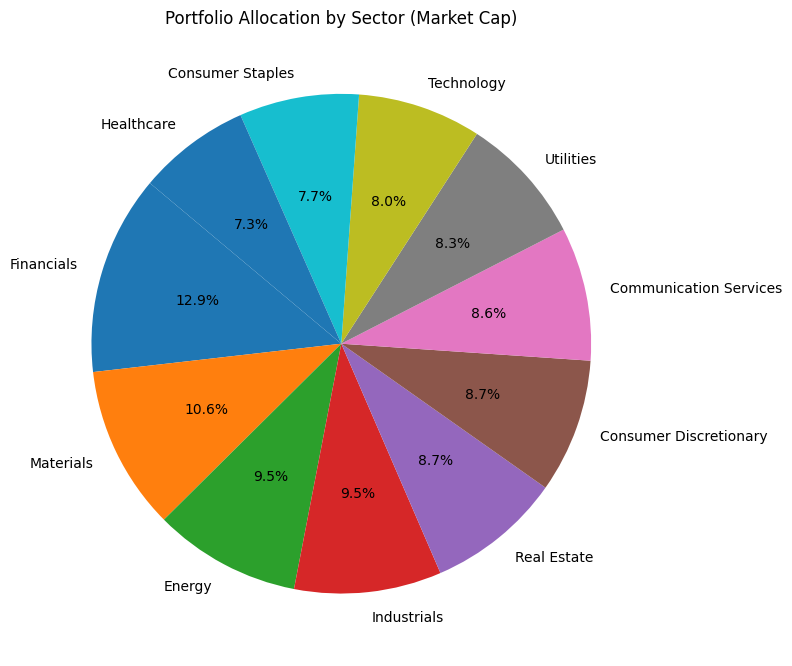

In [11]:
df.columns = df.columns.str.strip().str.replace(' ', '_')

sector_alloc = df.groupby('Sector')['Market_Cap'].sum().sort_values(ascending=False)

# Pie Chart - Sector Allocation
plt.figure(figsize=(8, 8))
sector_alloc.plot.pie(autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Allocation by Sector (Market Cap)")
plt.ylabel('')
plt.tight_layout()
plt.show()

###Volatilitas 52-Week

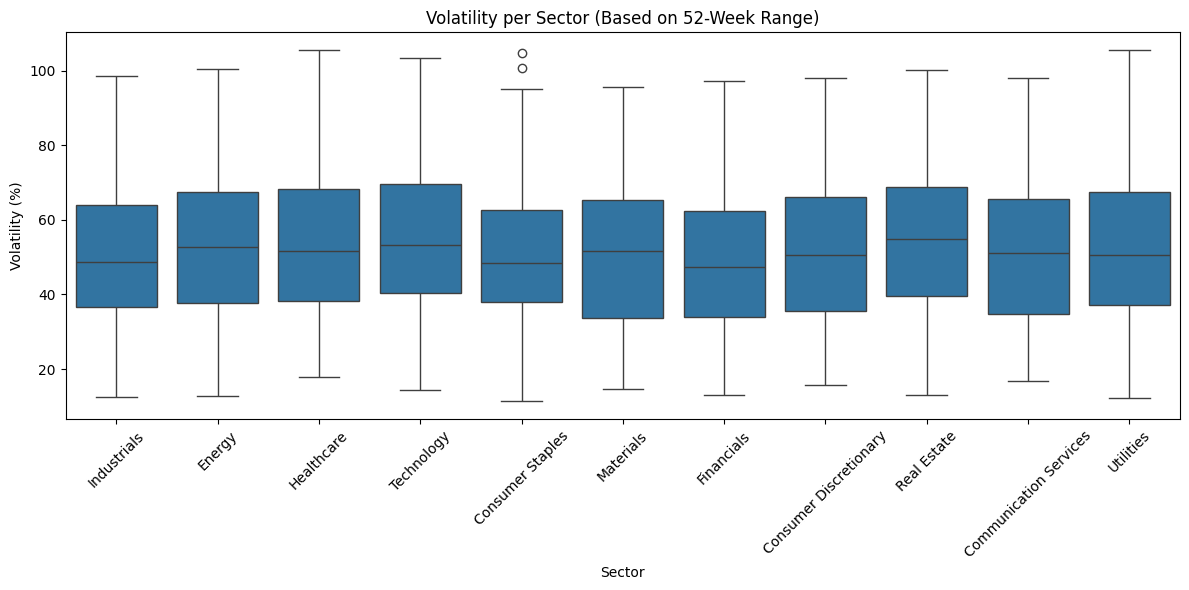

In [12]:
df['Volatility_%'] = ((df['52_Week_High'] - df['52_Week_Low']) / df['52_Week_Low']) * 100

# Boxplot per sektor
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Sector', y='Volatility_%')
plt.xticks(rotation=45)
plt.title("Volatility per Sector (Based on 52-Week Range)")
plt.ylabel("Volatility (%)")
plt.tight_layout()
plt.show()

###Valuasi Analisis Dengan P/E dan Dividend Yield

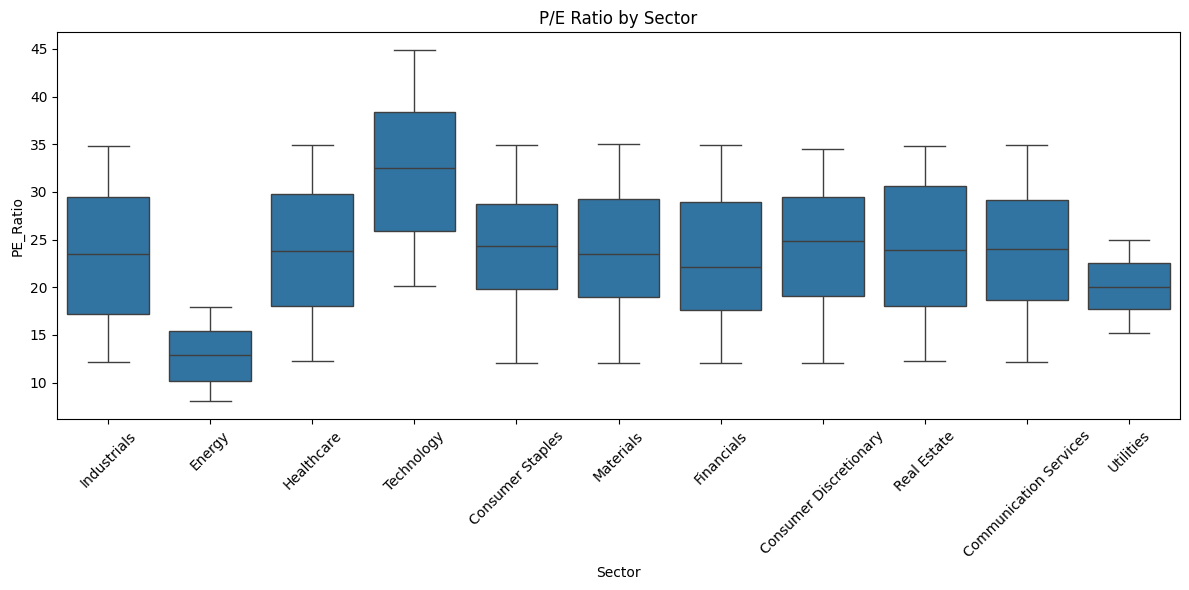

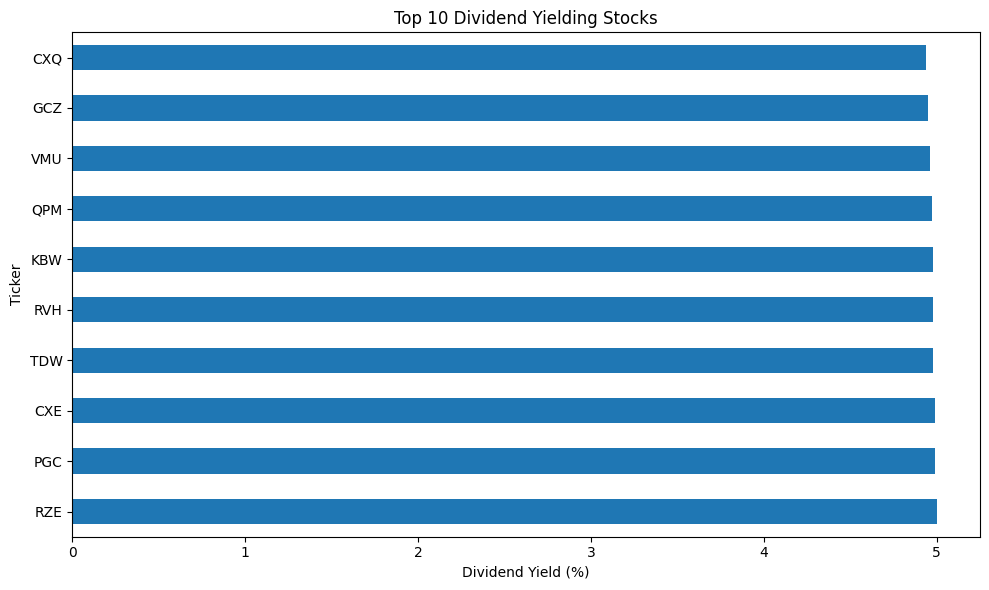

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sector', y='PE_Ratio', data=df)
plt.title("P/E Ratio by Sector")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_dividend = df.groupby('Ticker')['Dividend_Yield'].mean().sort_values(ascending=False).head(10)
top_dividend.plot(kind='barh', figsize=(10, 6), title="Top 10 Dividend Yielding Stocks")
plt.xlabel("Dividend Yield (%)")
plt.tight_layout()
plt.show()

###Technical Analysis (Support/Resistance)

In [14]:
# Pastikan kolom tanggal benar
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Ambil hanya Juni 2025
df_june = df[(df['Date'].dt.month == 6) & (df['Date'].dt.year == 2025)]

# Hitung support/resistance per hari dari seluruh saham
support_resistance_daily = df_june.groupby('Date').agg({
    'Low_Price': 'min',
    'High_Price': 'max'
}).rename(columns={
    'Low_Price': 'Market_Support',
    'High_Price': 'Market_Resistance'
}).reset_index()

support_resistance_daily.head()

,Date,Market_Support,Market_Resistance
0,2025-06-01,15.98,303.52
1,2025-06-02,14.99,304.47
2,2025-06-03,15.64,303.31
3,2025-06-04,24.20,306.23
4,2025-06-05,17.36,283.33


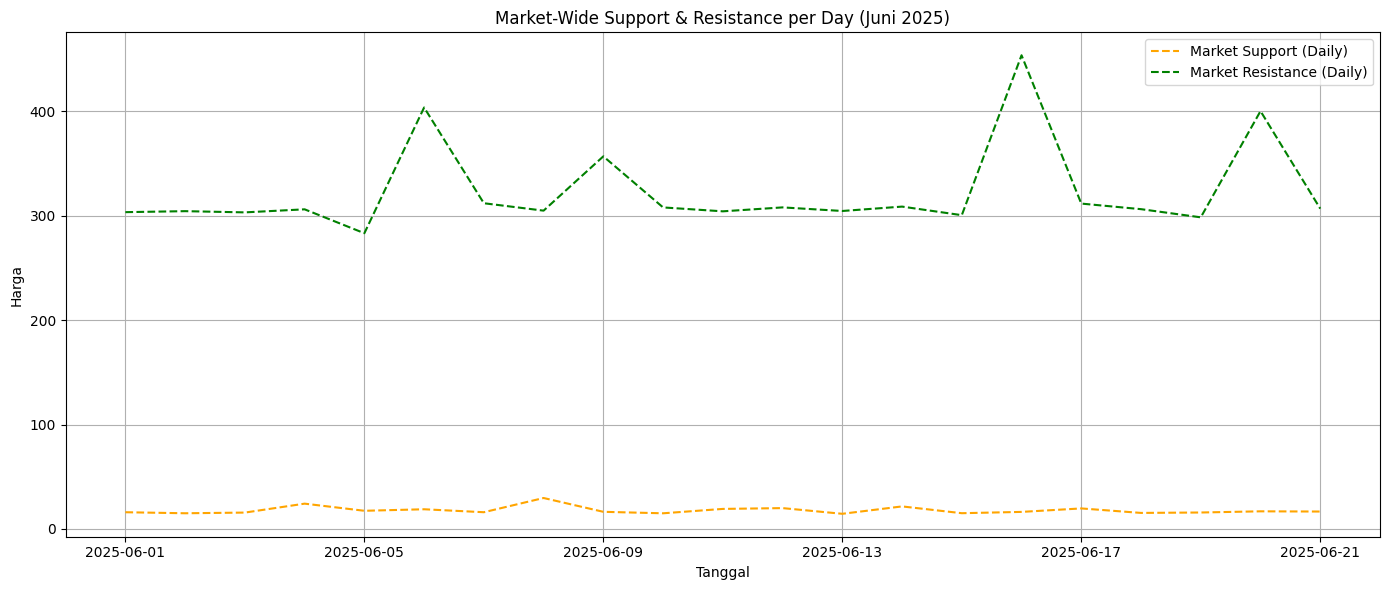

In [15]:

plt.figure(figsize=(14, 6))
plt.plot(support_resistance_daily['Date'], support_resistance_daily['Market_Support'], label='Market Support (Daily)', linestyle='--', color='orange')
plt.plot(support_resistance_daily['Date'], support_resistance_daily['Market_Resistance'], label='Market Resistance (Daily)', linestyle='--', color='green')

plt.title("Market-Wide Support & Resistance per Day (Juni 2025)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##Modeling

###Volatility Modeling: Risk assessment using price ranges and volume data


1. Hitung Volatilitas Harian
2. Agregasi Volatilitas per Ticker
3. Visualisasi Risiko Saham
4. Ranking Saham Berdasarkan Risiko



In [23]:
df['Price_Range_%'] = ((df['High_Price'] - df['Low_Price']) / df['Low_Price']) * 100

In [20]:
volatility_summary = df.groupby('Ticker').agg({
    'Price_Range_%': 'mean',
    'Volume_Traded': 'mean',
    'Sector': 'first'
}).reset_index()

volatility_summary = volatility_summary.rename(columns={
    'Price_Range_%': 'Avg_Volatility_%',
    'Volume_Traded': 'Avg_Volume'
})

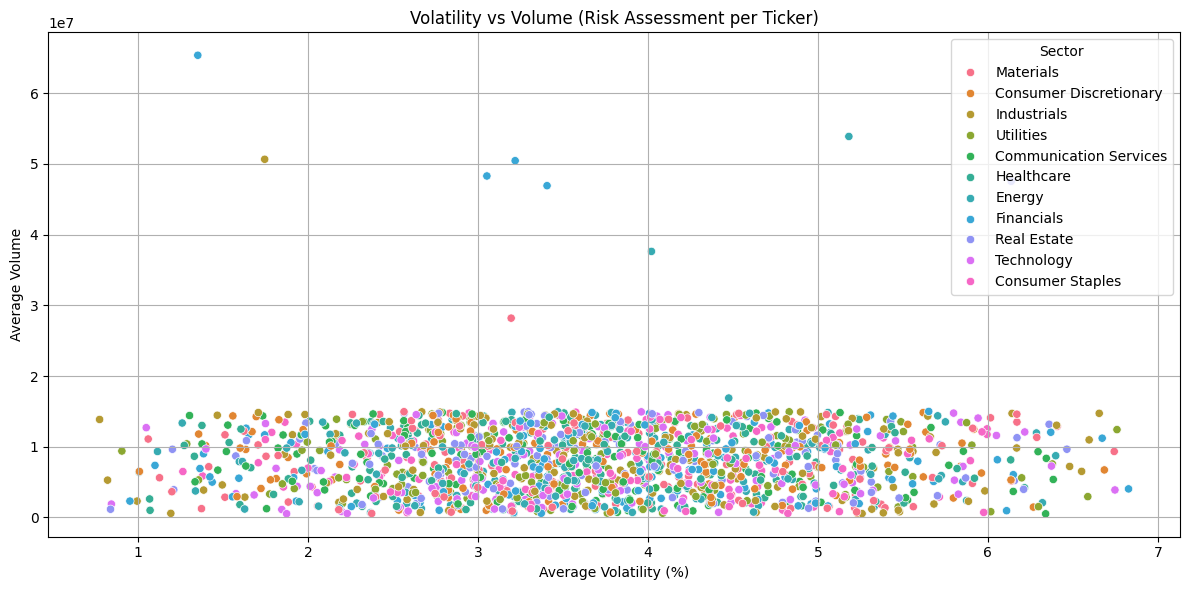

In [21]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=volatility_summary,
    x='Avg_Volatility_%',
    y='Avg_Volume',
    hue='Sector'
)
plt.title("Volatility vs Volume (Risk Assessment per Ticker)")
plt.xlabel("Average Volatility (%)")
plt.ylabel("Average Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Urutkan saham berdasarkan volatilitas tertinggi
top_risky_stocks = volatility_summary.sort_values('Avg_Volatility_%', ascending=False).head(10)
top_risky_stocks[['Ticker', 'Sector', 'Avg_Volatility_%', 'Avg_Volume']]

,Ticker,Sector,Avg_Volatility_%,Avg_Volume
830,MVG,Financials,6.827881,4037126.0
448,HAY,Utilities,6.759784,12423800.0
1350,UVI,Technology,6.747751,3886906.0
1553,XVQ,Materials,6.743555,9335428.0
115,BWK,Consumer Discretionary,6.685411,6721266.0
768,LVJ,Financials,6.672678,11211752.0
826,MUK,Industrials,6.655237,14728577.0
190,CWX,Industrials,6.595915,10972812.0
1492,WWY,Utilities,6.588080,2944997.0
818,MRU,Industrials,6.551789,6516777.0


MVG (Financials) adalah saham paling fluktuatif, meskipun volumenya relatif sedang.

Utilities & Industrials muncul cukup dominan dalam daftar ini — mencerminkan tingkat ketidakstabilan harga sektor-sektor tersebut di Juni 2025.

HAY dan MUK tidak hanya volatil, tetapi juga punya volume sangat tinggi (> 12 juta dan 14 juta) — cocok untuk strategi high risk, high liquidity.

##Kesimpulan Sementara
Sebagian besar saham berada pada rentang volatilitas rendah hingga sedang (1–4%).

Ditemukan beberapa saham dengan volume tinggi dan volatilitas tinggi, yang menjadi kandidat potensial untuk strategi trading agresif.

Profil sektor menunjukkan distribusi risiko yang beragam; sektor finansial dan energi memiliki volume dominan.

##Pertimbangan Teknis
Outlier handling dipertimbangkan untuk kebutuhan visualisasi dan clustering, tetapi tetap dipertahankan untuk analisis risiko yang representatif.

Data yang digunakan hanya mencakup periode 1 bulan, sehingga interpretasi rolling analysis dilakukan secara terbatas.